In [1]:
import seaborn as sns
import pandas as pd

In [2]:
df_train = pd.read_csv("data/technical/sales_train.csv")
feature_names = ['date_block_num', 'shop_id', 'item_id', 'item_price']
df_features = df_train[feature_names]

# Check Correlation between the features

[Source for the formatting](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec)

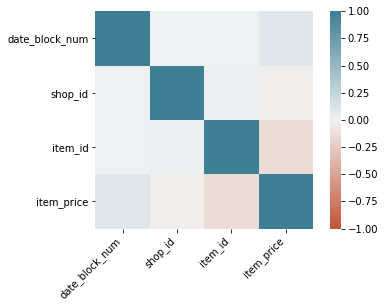

In [3]:
corr = df_features.corr()

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Little to no correlation found between the features:**

`item_id` gives us a negative correlation, which is to be expected.

The only tiny correlation to be found is regarding the price of the item.
`item_price` shows the darkest spot on the graph.

Cite correlation interpretation: `978-1-4614-7138-7` - p. 156